## Taxi trip data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# a nice way of filtering out deprecated warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
yellow = pd.read_csv("../raw_data/yellow_tripdata_2018-02.csv")

yellow.tail()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
8492071,2,2018-02-28 23:21:56,2018-02-28 23:47:43,6,9.61,1,N,138,163,2,28.5,0.5,0.5,0.0,5.54,0.3,35.34
8492072,2,2018-02-28 23:54:07,2018-03-01 00:24:56,6,4.20,1,N,230,230,1,21.5,0.5,0.5,0.0,0.00,0.3,22.80
8492073,2,2018-02-28 23:17:42,2018-02-28 23:53:11,1,0.00,1,N,193,193,2,0.0,0.0,0.0,0.0,0.00,0.0,0.00
8492074,2,2018-03-01 13:39:17,2018-03-01 13:49:08,2,0.00,1,N,264,264,2,2.4,0.0,0.5,0.0,0.00,0.3,3.20
8492075,2,2018-02-28 23:03:18,2018-02-28 23:03:24,1,0.00,1,N,264,193,1,0.0,0.0,0.0,0.0,0.00,0.0,0.00


In [3]:
# Preprocessing on trip data

from datetime import datetime

# remove invalid vendor ID trips
yellow = yellow[(yellow['VendorID'] == 1) | (yellow['VendorID'] == 2)]

# convert time from string to datetime
yellow['tpep_pickup_datetime'] = pd.to_datetime(yellow['tpep_pickup_datetime'])
yellow['tpep_dropoff_datetime'] = pd.to_datetime(yellow['tpep_dropoff_datetime'])

# early feature engineering here for time difference in minutes
yellow['time_duration'] = round(((yellow['tpep_dropoff_datetime'] - yellow['tpep_pickup_datetime']).dt.seconds / 60), 1)

# remove invalid time
processed_yellow = yellow[yellow['tpep_pickup_datetime'].dt.year == 2018]
processed_yellow = processed_yellow[processed_yellow['tpep_pickup_datetime'].dt.month == 2]
processed_yellow = processed_yellow[(processed_yellow['tpep_dropoff_datetime'].dt.month == 2) | (processed_yellow['tpep_dropoff_datetime'].dt.month == 3)]

# remove unusual time duration
processed_yellow = processed_yellow[(processed_yellow['time_duration'] > 1) & (processed_yellow['time_duration'] < 120)] 

# remove <1 or >6 passenger 
# https://www1.nyc.gov/site/tlc/passengers/passenger-frequently-asked-questions.page
processed_yellow = processed_yellow[(processed_yellow['passenger_count'] >= 1) & (processed_yellow['passenger_count'] <= 6)]

# remove unusual trip distance
processed_yellow = processed_yellow[(processed_yellow['trip_distance'] > 0.1) & (processed_yellow['trip_distance'] < 200)]

# remove unusually high speed (average >80mph) trip
processed_yellow = processed_yellow[(processed_yellow['trip_distance'] / processed_yellow['time_duration'] * 60) < 80]

# remove other rate code as only considering standard rate and JFK rate
# at the same time remove invalid JFK rate trip (neither pick-up or drop-off at JFK airport)
processed_yellow = processed_yellow[(processed_yellow['RatecodeID'] == 1) | ((processed_yellow['RatecodeID'] == 2) & ((processed_yellow['PULocationID'] == 132) | (processed_yellow['DOLocationID'] == 132)))]

# remove invalid payment type and cash(as tip is not included)
processed_yellow = processed_yellow[processed_yellow['payment_type'] == 1]

# remove invalid fare amount 
# https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page
processed_yellow = processed_yellow[((processed_yellow['RatecodeID'] == 1) & (processed_yellow['fare_amount'] >= 2.5)) | ((processed_yellow['RatecodeID'] == 2) & (processed_yellow['fare_amount'] == 52))]

# remove no tax applied trip
processed_yellow = processed_yellow[processed_yellow['mta_tax'] == 0.5]

# remove <2.5 (initial charge) total amount
processed_yellow = processed_yellow[processed_yellow['total_amount'] >= 2.5]

# remove <10% tip amount trip due to research
## https://www.tripsavvy.com/guide-to-tipping-in-new-york-city-4177115
processed_yellow = processed_yellow[processed_yellow['tip_amount'] > 0.1*(processed_yellow['total_amount'])]

# remove unusual or invalid (less than fare or tip amount) total amount
processed_yellow = processed_yellow[processed_yellow['total_amount'] < 500]
processed_yellow = processed_yellow[(processed_yellow['total_amount'] > processed_yellow['fare_amount']) & (processed_yellow['total_amount'] > processed_yellow['tip_amount'])]

processed_yellow


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,time_duration
5,2,2018-02-01 00:04:35,2018-02-01 00:23:09,1,5.95,1,N,231,80,1,20.5,0.5,0.5,5.45,0.0,0.3,27.25,18.6
8,1,2018-02-01 00:01:07,2018-02-01 00:08:43,2,2.60,1,N,144,25,1,10.0,0.5,0.5,2.25,0.0,0.3,13.55,7.6
9,1,2018-02-01 00:10:47,2018-02-01 00:26:52,1,3.10,1,N,234,50,1,13.0,0.5,0.5,2.85,0.0,0.3,17.15,16.1
11,1,2018-02-01 00:52:22,2018-02-01 01:07:24,1,4.00,1,N,239,244,1,15.0,0.5,0.5,4.05,0.0,0.3,20.35,15.0
15,1,2018-02-01 00:46:43,2018-02-01 00:56:00,2,3.00,1,N,229,75,1,11.0,0.5,0.5,2.45,0.0,0.3,14.75,9.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8492064,1,2018-02-28 23:37:02,2018-03-01 00:10:46,2,7.80,1,N,48,33,1,28.5,0.5,0.5,7.45,0.0,0.3,37.25,33.7
8492065,2,2018-02-28 23:16:45,2018-02-28 23:20:06,1,0.51,1,N,140,237,1,4.5,0.5,0.5,0.75,0.0,0.3,6.55,3.4
8492066,2,2018-02-28 23:43:24,2018-02-28 23:58:47,1,5.25,1,N,170,261,1,18.0,0.5,0.5,2.70,0.0,0.3,22.00,15.4
8492068,2,2018-02-28 23:08:37,2018-02-28 23:34:42,1,5.53,1,N,162,13,1,22.0,0.5,0.5,5.00,0.0,0.3,28.30,26.1


In [4]:
# Check missing value

processed_yellow.isnull().sum()


VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
time_duration            0
dtype: int64

In [6]:
# Since too many congestion surcharge are missing for some month (2019-01),
# Therefore, I assume missing means no surcharge applied. 
# Also, by observation of the data, the congestion surcharge does not count into total amount, 
# which there may be some other calculating way that is not provided

# for 2018 data, don't even have 'congestion_surcharge' data
if (processed_yellow['tpep_pickup_datetime'].dt.year[0] == 2018):
    processed_yellow['congestion_surcharge'] = 0
                     
processed_yellow['congestion_surcharge'] = processed_yellow['congestion_surcharge'].fillna(0)

In [7]:
# Save preprocessed trip data in feather format
processed_yellow = processed_yellow.reset_index().drop('index', axis=1)

processed_yellow.to_feather("../preprocessed_data/yellow_tripdata_2018-02")

## Shapefile fix

In [2]:
import geopandas as gpd

import folium
from folium.plugins import FastMarkerCluster
from folium.plugins import HeatMap

from bokeh.plotting import figure, show
from bokeh.tile_providers import get_provider, Vendors
from bokeh.io import save, reset_output, output_notebook

from bokeh.models import ColorBar, LinearColorMapper
from bokeh.palettes import all_palettes

In [3]:
# sf stands for shape file
sf = gpd.read_file("../raw_data/taxi_zones/taxi_zones.shp")

# Convert the geometry shape to to latitude and longitude
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")


In [ ]:
# Check if there is any duplicated location id and yes there is

sf[sf.duplicated(subset='LocationID') == True]

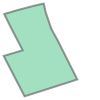

In [4]:
# Compare the geometry graph with the map 

sf.iloc[56].geometry

# It's found that this is actually 57

In [ ]:
# Compare the geometry graph with the map 

sf.iloc[103].geometry

# It's found that this is actually 104

In [ ]:
# Compare the geometry graph with the map 

sf.iloc[104].geometry

# It's found that this is actually 105

In [5]:
# Therefore we fix the shape file data

sf.loc[56,'LocationID'] = 57
sf.loc[103,'LocationID'] = 104
sf.loc[104,'LocationID'] = 105


In [ ]:
sf

## External hotel data

In [43]:
# Import hotel data
## https://data.cityofnewyork.us/City-Government/Hotels-Properties-Citywide/tjus-cn27

hotel = pd.read_csv("../raw_data/Hotels_Properties_Citywide.csv")

hotel

,PARID,BOROCODE,BLOCK,LOT,TAXYEAR,STREET NUMBER,STREET NAME,Postcode,BLDG_CLASS,TAXCLASS,OWNER_NAME,Borough,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,1000080039,1,8,39,2021,32,PEARL STREET,10004,H3,4,"32 PEARL, LLC",MANHATTAN,40.703235,-74.012421,101.0,1.0,9.0,1078968.0,1.000080e+09,Battery Park City-Lower Manhattan
1,1000080051,1,8,51,2021,6,WATER STREET,10004,H2,4,AI IV LLC,MANHATTAN,40.702744,-74.012201,101.0,1.0,9.0,1090472.0,1.000080e+09,Battery Park City-Lower Manhattan
2,1000100033,1,10,33,2021,8,STONE STREET,10004,H2,4,"B.H. 8 STONE STREET AG, LLC",MANHATTAN,40.704025,-74.012638,101.0,1.0,9.0,1087618.0,1.000100e+09,Battery Park City-Lower Manhattan
3,1000110029,1,11,29,2021,11,STONE STREET,10004,H2,4,"PREMIER EMERALD, LLC",MANHATTAN,40.704039,-74.012317,101.0,1.0,9.0,1000041.0,1.000110e+09,Battery Park City-Lower Manhattan
4,1000161301,1,16,1301,2021,102,NORTH END AVENUE,10282,RH,4,GOLDMAN SACHS,MANHATTAN,40.714812,-74.016153,101.0,1.0,31703.0,1085867.0,1.000168e+09,Battery Park City-Lower Manhattan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5514,5038750026,5,3875,26,2022,630,MIDLAND AVENUE,10306,H4,4,630 MIDLAND CORP,5,40.571192,-74.091057,2.0,50.0,11202.0,5055032.0,5.038750e+09,New Dorp-Midland Beach
5515,5066680094,5,6668,94,2022,51,WILBUR STREET,10309,H4,4,A GUDDEMI,5,40.515283,-74.194552,3.0,51.0,198.0,5082754.0,5.066680e+09,Annadale-Huguenot-Prince's Bay-Eltingville
5516,5070670090,5,7067,90,2022,39,ST LUKES AVENUE,10309,HB,4,JOHN VINCENT SCALIA,5,40.553824,-74.216904,3.0,51.0,20801.0,5086591.0,5.070670e+09,Rossville-Woodrow
5517,5073650001,5,7365,1,2022,2600,VETERANS ROAD WEST,10309,H4,4,M & R ENTERPRISES OF,5,40.533481,-74.224756,3.0,51.0,226.0,5086844.0,5.073650e+09,Charleston-Richmond Valley-Tottenville


In [44]:
# drop duplicates

hotel = hotel.drop_duplicates(subset='PARID')
hotel = hotel.drop_duplicates(subset=['Latitude','Longitude','BLOCK','STREET NUMBER'])

hotel

,PARID,BOROCODE,BLOCK,LOT,TAXYEAR,STREET NUMBER,STREET NAME,Postcode,BLDG_CLASS,TAXCLASS,OWNER_NAME,Borough,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,1000080039,1,8,39,2021,32,PEARL STREET,10004,H3,4,"32 PEARL, LLC",MANHATTAN,40.703235,-74.012421,101.0,1.0,9.0,1078968.0,1.000080e+09,Battery Park City-Lower Manhattan
1,1000080051,1,8,51,2021,6,WATER STREET,10004,H2,4,AI IV LLC,MANHATTAN,40.702744,-74.012201,101.0,1.0,9.0,1090472.0,1.000080e+09,Battery Park City-Lower Manhattan
2,1000100033,1,10,33,2021,8,STONE STREET,10004,H2,4,"B.H. 8 STONE STREET AG, LLC",MANHATTAN,40.704025,-74.012638,101.0,1.0,9.0,1087618.0,1.000100e+09,Battery Park City-Lower Manhattan
3,1000110029,1,11,29,2021,11,STONE STREET,10004,H2,4,"PREMIER EMERALD, LLC",MANHATTAN,40.704039,-74.012317,101.0,1.0,9.0,1000041.0,1.000110e+09,Battery Park City-Lower Manhattan
4,1000161301,1,16,1301,2021,102,NORTH END AVENUE,10282,RH,4,GOLDMAN SACHS,MANHATTAN,40.714812,-74.016153,101.0,1.0,31703.0,1085867.0,1.000168e+09,Battery Park City-Lower Manhattan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5454,4100310007,4,10031,7,2022,147-16,97 AVENUE,11435,H3,4,UMBRELLA INVESTORS LLC,4,40.697436,-73.805263,12.0,28.0,208.0,4214599.0,4.100310e+09,Jamaica
5458,4100411001,4,10041,1001,2022,143-18,LIBERTY AVENUE,11435,RH,4,LIBERTY HOSPITALITY LLC,4,40.692296,-73.809479,12.0,28.0,202.0,4440168.0,4.100410e+09,South Jamaica
5459,4101010027,4,10101,27,2022,92-32,UNION HALL STREET,11433,H3,4,NEW CHRYSTIE LLC,4,40.703771,-73.797652,12.0,27.0,44601.0,4215619.0,4.101010e+09,Jamaica
5463,4107590167,4,10759,167,2022,95-10,218 STREET,11429,H3,4,218 ST NY LLC,4,40.717577,-73.737406,13.0,27.0,568.0,4230658.0,4.107590e+09,Queens Village


In [45]:
# Preprocessing on hotel data
# Assume all hotels build before 2018 since do not have those information

processed_hotel = hotel[hotel['BOROCODE'] == 1].dropna().reset_index()

processed_hotel['index'] = processed_hotel.index

processed_hotel

,index,PARID,BOROCODE,BLOCK,LOT,TAXYEAR,STREET NUMBER,STREET NAME,Postcode,BLDG_CLASS,...,OWNER_NAME,Borough,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,0,1000080039,1,8,39,2021,32,PEARL STREET,10004,H3,...,"32 PEARL, LLC",MANHATTAN,40.703235,-74.012421,101.0,1.0,9.0,1078968.0,1.000080e+09,Battery Park City-Lower Manhattan
1,1,1000080051,1,8,51,2021,6,WATER STREET,10004,H2,...,AI IV LLC,MANHATTAN,40.702744,-74.012201,101.0,1.0,9.0,1090472.0,1.000080e+09,Battery Park City-Lower Manhattan
2,2,1000100033,1,10,33,2021,8,STONE STREET,10004,H2,...,"B.H. 8 STONE STREET AG, LLC",MANHATTAN,40.704025,-74.012638,101.0,1.0,9.0,1087618.0,1.000100e+09,Battery Park City-Lower Manhattan
3,3,1000110029,1,11,29,2021,11,STONE STREET,10004,H2,...,"PREMIER EMERALD, LLC",MANHATTAN,40.704039,-74.012317,101.0,1.0,9.0,1000041.0,1.000110e+09,Battery Park City-Lower Manhattan
4,4,1000161301,1,16,1301,2021,102,NORTH END AVENUE,10282,RH,...,GOLDMAN SACHS,MANHATTAN,40.714812,-74.016153,101.0,1.0,31703.0,1085867.0,1.000168e+09,Battery Park City-Lower Manhattan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,719,1018950064,1,1895,64,2022,606,WEST 114 STREET,10025,H8,...,TRUSTEES OF COLUMBIA UNIVERSITY,1,40.806995,-73.965564,9.0,7.0,199.0,1057352.0,1.018950e+09,Morningside Heights
720,720,1018950072,1,1895,72,2022,626,WEST 114 STREET,10025,H8,...,TRUSTEES OF COLUMBIA UNIVERSITY FACILITI ES MA...,1,40.807168,-73.965973,9.0,7.0,199.0,1057357.0,1.018950e+09,Morningside Heights
721,721,1018960083,1,1896,83,2022,620,WEST 116 STREET,10027,H8,...,BARNARD COLLEGE,1,40.808626,-73.965322,9.0,7.0,205.0,1057385.0,1.018960e+09,Morningside Heights
722,722,1019410026,1,1941,26,2022,205,WEST 135 STREET,10030,HH,...,205 WEST 135 LLC,1,40.815526,-73.944198,10.0,9.0,228.0,1058890.0,1.019410e+09,Central Harlem North-Polo Grounds


In [46]:
# Convert coordinate of hotel to zone ID

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

hotel_coordinate = processed_hotel[['Longitude', 'Latitude']]

coordinate_to_zone = []
for index, row in hotel_coordinate.iterrows():
    restart = False
    point = Point(row['Longitude'], row['Latitude'])
    for i, r in sf.iterrows():
        if (restart == True):
            continue
        if (r.geometry.geom_type != 'MultiPolygon'):
            polygon = Polygon(r.geometry)
            if (polygon.contains(point)):
                coordinate_to_zone.append(r.LocationID)
                restart = True
            else:
                if (i == len(sf)-1):
                    coordinate_to_zone.append(0)
        else:
            if (i==28): # the only special zone
                polygon = Polygon(r.geometry[1])
            else:
                polygon = Polygon(r.geometry[0])
            if (polygon.contains(point)):
                coordinate_to_zone.append(r.LocationID)
                restart = True


In [47]:
# Add zone ID to hotel data

hotel_zone = pd.DataFrame(coordinate_to_zone, columns =['LocationID']).reset_index()

processed_hotel = pd.merge(processed_hotel, hotel_zone, left_on='index', right_on='index')

processed_hotel = processed_hotel[processed_hotel['LocationID'] != 0].drop('index', axis=1)

processed_hotel

,PARID,BOROCODE,BLOCK,LOT,TAXYEAR,STREET NUMBER,STREET NAME,Postcode,BLDG_CLASS,TAXCLASS,...,Borough,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,LocationID
0,1000080039,1,8,39,2021,32,PEARL STREET,10004,H3,4,...,MANHATTAN,40.703235,-74.012421,101.0,1.0,9.0,1078968.0,1.000080e+09,Battery Park City-Lower Manhattan,88
1,1000080051,1,8,51,2021,6,WATER STREET,10004,H2,4,...,MANHATTAN,40.702744,-74.012201,101.0,1.0,9.0,1090472.0,1.000080e+09,Battery Park City-Lower Manhattan,88
2,1000100033,1,10,33,2021,8,STONE STREET,10004,H2,4,...,MANHATTAN,40.704025,-74.012638,101.0,1.0,9.0,1087618.0,1.000100e+09,Battery Park City-Lower Manhattan,88
3,1000110029,1,11,29,2021,11,STONE STREET,10004,H2,4,...,MANHATTAN,40.704039,-74.012317,101.0,1.0,9.0,1000041.0,1.000110e+09,Battery Park City-Lower Manhattan,88
4,1000161301,1,16,1301,2021,102,NORTH END AVENUE,10282,RH,4,...,MANHATTAN,40.714812,-74.016153,101.0,1.0,31703.0,1085867.0,1.000168e+09,Battery Park City-Lower Manhattan,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,1018950064,1,1895,64,2022,606,WEST 114 STREET,10025,H8,4,...,1,40.806995,-73.965564,9.0,7.0,199.0,1057352.0,1.018950e+09,Morningside Heights,166
720,1018950072,1,1895,72,2022,626,WEST 114 STREET,10025,H8,4,...,1,40.807168,-73.965973,9.0,7.0,199.0,1057357.0,1.018950e+09,Morningside Heights,166
721,1018960083,1,1896,83,2022,620,WEST 116 STREET,10027,H8,4,...,1,40.808626,-73.965322,9.0,7.0,205.0,1057385.0,1.018960e+09,Morningside Heights,166
722,1019410026,1,1941,26,2022,205,WEST 135 STREET,10030,HH,4,...,1,40.815526,-73.944198,10.0,9.0,228.0,1058890.0,1.019410e+09,Central Harlem North-Polo Grounds,42


In [51]:
# Save preprocessed hotel data in feather format

processed_hotel.to_feather("../preprocessed_data/processed_hotel")

### not used at the end

In [ ]:
# NYC Hotel Occupancy, ADR & Room Demand
# https://assets.simpleviewinc.com/simpleview/image/upload/v1/clients/newyorkcity/FYI_HotelPerformance_5Year_22821_dk_82d984c7-b953-4b74-a906-0db91402564b.pdf

Month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
Occ = [73.2, 78.1, 84.4, 89.2, 90.7, 90.8, 89.8, 90.7, 91.0, 91.7, 89.4, 90.9]

hotel_occupancy = pd.DataFrame({'Month': Month, 'OccPercentage': Occ}) # .sort_values(by=['OccPercentage'], ascending=False)
hotel_occupancy

In [ ]:
# Save hotel occupancy data in feather format

hotel_occupancy.to_feather("../preprocessed_data/hotel_occupancy")

## External Climate Data

In [2]:
# Import climate data
# https://www.ncdc.noaa.gov/cdo-web/datatools/findstation

weather = pd.read_csv("../raw_data/weather.csv")

weather

,STATION,NAME,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WT01,WT02,WT03,WT04,WT06,WT08
0,USW00094728,"NY CITY CENTRAL PARK, NY US",2018-01-01,7.83,0.00,0.0,0.0,NaN,19,7,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00094728,"NY CITY CENTRAL PARK, NY US",2018-01-02,8.05,0.00,0.0,0.0,NaN,26,13,NaN,NaN,NaN,NaN,NaN,NaN
2,USW00094728,"NY CITY CENTRAL PARK, NY US",2018-01-03,3.13,0.00,0.0,0.0,NaN,30,16,NaN,NaN,NaN,NaN,NaN,NaN
3,USW00094728,"NY CITY CENTRAL PARK, NY US",2018-01-04,12.53,0.76,9.8,1.2,NaN,29,19,1.0,1.0,NaN,NaN,NaN,1.0
4,USW00094728,"NY CITY CENTRAL PARK, NY US",2018-01-05,12.97,0.00,0.0,7.1,NaN,19,9,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,USW00094728,"NY CITY CENTRAL PARK, NY US",2019-03-27,4.03,0.00,0.0,0.0,NaN,47,34,NaN,NaN,NaN,NaN,NaN,NaN
451,USW00094728,"NY CITY CENTRAL PARK, NY US",2019-03-28,1.57,0.00,0.0,0.0,NaN,53,37,NaN,NaN,NaN,NaN,NaN,NaN
452,USW00094728,"NY CITY CENTRAL PARK, NY US",2019-03-29,2.01,0.00,0.0,0.0,NaN,59,49,NaN,NaN,NaN,NaN,NaN,NaN
453,USW00094728,"NY CITY CENTRAL PARK, NY US",2019-03-30,3.36,0.00,0.0,0.0,NaN,70,52,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf

# STATION = The station identification code
# DATE = The year of the record (4 digits) followed by month (2 digits) and day (2 digits)
# AWND = Average daily wind speed
# PRCP = Precipitation (inches to hundredths)
# SNOW = Snowfall (inches to tenths)
# SNWD = Snow depth (inches)
# TAVG = Average temperature (Fahrenheit) 
# TMAX = Maximum temperature (Fahrenheit) 
# TMIN = Minimum temperature (Fahrenheit)
# WT01 = Fog, ice fog, or freezing fog (may include heavy fog)
# WT02 = Heavy fog or heaving freezing fog (not always distinguished from fog)
# WT03 = Thunder
# WT04 = Ice pellets, sleet, snow pellets, or small hail 
# WT06 = Glaze or rime 
# WT08 = Smoke or haze 

In [ ]:
# Check TAVG data

weather[weather['TAVG'].isnull()]

In [ ]:
# Check AWND data

weather[weather['AWND'].isnull()]

In [ ]:
# Preprocessing the weather data

processed_weather = weather

# Convert date to string type
processed_weather['DATE'] = processed_weather['DATE'].astype(str)

# Insert 0 to null wind data
processed_weather['AWND'] = processed_weather['AWND'].fillna(0)

# Insert average temperature by calculating the mean of max and min for empty column
processed_weather['TAVG'] = (processed_weather['TMAX'] + processed_weather['TMIN']) / 2

# Add 'WT'(weather type) column which categoried into good or bad
processed_weather['WT'] = processed_weather[['WT01', 'WT02', 'WT03', 'WT04', 'WT06', 'WT08']].sum(axis=1)
processed_weather['WT'] = np.where(processed_weather['WT'] > 0, 'bad', 'good')

# Drop unwanted data
processed_weather = processed_weather.drop(['STATION', 'NAME', 'TMAX', 'TMIN', 'WT01', 'WT02', 'WT03', 'WT04', 'WT06', 'WT08'], axis=1)

processed_weather

In [ ]:
# Save weather data in feather format

processed_weather.to_feather("../preprocessed_data/processed_weather")